In [1]:
%load_ext autoreload

%autoreload 2

In [2]:
import chainer
from chainer import links as L
from chainer import functions as F
from chainer import optimizers

from generate_input import load_images_from_folder

from chainer import reporter

from chainer import backend
from chainer import backends
from chainer.backends import cuda
from chainer import Function, gradient_check, report, training, utils, Variable
from chainer import  initializers, iterators, optimizers, serializers
from chainer.training import extensions

import numpy as np

In [3]:
import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
class MRICNN(chainer.Chain):
    def __init__(self, x_shape):
        super(MRICNN, self).__init__()
        size=(64, 1, 5, 5)
        n = size[0] * size[2] * size[3] + size[1] * size[2] * size[3]
        a = np.sqrt(6/n)
        W1 = self.xp.random.uniform(high=a, low=a, size=size)

        size=(64, 64, 5, 5)
        n = size[0] * size[2] * size[3] + size[1] * size[2] * size[3]
        a = np.sqrt(6/n)
        W2 = self.xp.random.uniform(high=a, low=a, size=size)
        
        size=(64, 1, 7, 7)
        n = size[0] * size[2] * size[3] + size[1] * size[2] * size[3]
        a = np.sqrt(6/n)
        W3 = self.xp.random.uniform(high=a, low=a, size=size)
        
        
        with self.init_scope():
            n_out = int(x_shape[0]*x_shape[1])
            self.fc1 = L.Linear(None, n_out)
            self.fc2 = L.Linear(None, n_out)
#             self.conv1 = L.Convolution2D(in_channels=1, out_channels=64, ksize=3, pad=2)
#             self.conv2 = L.Convolution2D(in_channels=64,out_channels=64, ksize=3, pad=2)
#             self.deconv = L.Deconvolution2D(in_channels=64, out_channels=1, ksize=5)

            self.conv1  = L.Convolution2D(in_channels=1, out_channels=64, ksize=5, pad=4)
            self.conv2  = L.Convolution2D(in_channels=64,out_channels=64, ksize=5, pad=4)
            self.deconv = L.Deconvolution2D(in_channels=64, out_channels=1, ksize=7)

#             self.conv1 = L.Convolution2D(in_channels=1, out_channels=64, ksize=5, initialW=W1, pad=4)
#             self.conv2 = L.Convolution2D(in_channels=64, out_channels=64, ksize=5, initialW=W2, pad=4)
#             self.deconv = L.Deconvolution2D(in_channels=64, out_channels=1, ksize=7, initialW=W3)
        
    def __call__(self, x):
        h = x.reshape(x.shape[0], -1)
        
        h = self.fc1(h)
        h = F.tanh(h)
        h = self.fc2(h)
        h = F.tanh(h)
        h = h.reshape(x.shape[0], 1, x.shape[1], x.shape[2])
#         print(h.shape)
        h = self.conv1(h)
        h = F.relu(h)
#         print(h.shape)
        h = self.conv2(h)
        h = F.relu(h)
#         print(h.shape)
        h = self.deconv(h)
        h = h[:, :, 7:-7, 7:-7]
#         print(h.shape)
        
        return h


In [5]:
def compute_cost(x, y):
    x = x[:, 0, :, :]
    cost = F.mean_squared_error(x, y)
    return cost

In [71]:
class Minimizer(chainer.Chain):
    def __init__(self, model, loss_fun):
        super(Minimizer, self).__init__()
        with self.init_scope():
            self.model = model
            
        self.loss_fun = loss_fun
        self.noise = True
        self.report = True
        
    def forward(self, *args):
        if self.noise:
            noise = self.xp.random.normal(size=args[0].shape)
            noise = noise.astype(np.float32)
        else:
            noise = 0
        self.y = self.model(args[0] + noise)
        self.loss = self.loss_fun(self.y, args[1])
        if self.report:
            reporter.report({'loss':self.loss}, self)
        return self.loss

In [19]:
dir_train = '/home/genta/dataset/tiny-imagenet-200/test/images/'  # Folder with images
n_im = 10000  # How many images to load
X_train, Y_train = load_images_from_folder(  # Load images for training
    dir_train,
    n_im,
    normalize=False,
    imrotate=True,
    search_dirs = None
)
print('X_train.shape at input = ', X_train.shape)
print('Y_train.shape at input = ', Y_train.shape)

X_train.shape at input =  (40000, 64, 64, 2)
Y_train.shape at input =  (40000, 64, 64)


In [20]:
print(X_train.max(), X_train.min(), X_train.mean())
print(Y_train.max(), Y_train.min(), Y_train.mean())

998226.0 -262647.515201 56.302675
255.0 0.0 113.429427441


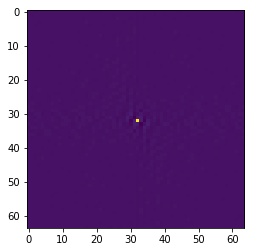

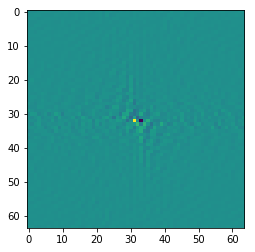

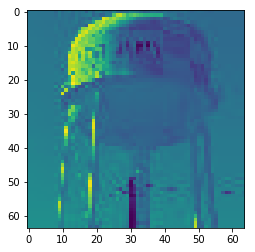

In [21]:
plt.imshow(X_train[0][:, :, 0])
plt.show()

plt.imshow(X_train[0][:, :, 1])
plt.show()

plt.imshow(Y_train[0])
plt.show()

In [22]:
X_train = X_train.astype(np.float32)
Y_train = Y_train.astype(np.float32)
Y_train = Y_train - Y_train.min()
Y_train /= Y_train.max()

In [23]:
n_test = X_train.shape[0]//4
train = [(i, j) for i, j in zip(X_train[n_test:, :], Y_train[n_test:, :])]
test = [(i, j) for i, j in zip(X_train[:n_test, :], Y_train[:n_test, :])]

In [24]:
len(train), len(test)

(30000, 10000)

In [25]:
def main():
    max_epoch = 10
    gpu_id = 0
    lr = 0.0002
    batchsize = 100

    train_iter = iterators.SerialIterator(train, batchsize)
    test_iter = iterators.SerialIterator(test, batchsize, False, False)

    preditor = MRICNN(X_train[0].shape)
    preditor.to_gpu()
    model = Minimizer(preditor, compute_cost)
    optimizer = optimizers.RMSprop(lr=lr, alpha=0.9)
#     optimizer = optimizers.MomentumSGD(lr=lr, momentum=0.9)
#     optimizer = optimizers.Adam(alpha=lr)
#     optimizer = optimizers.NesterovAG(lr=lr)
    optimizer.setup(model)
    optimizer.add_hook(chainer.optimizer_hooks.Lasso(0.0001))

    updater = training.updaters.StandardUpdater(train_iter, optimizer, device=gpu_id)
    trainer = training.Trainer(updater, (max_epoch, 'epoch'), out='result')
    trainer.extend(extensions.LogReport())
    trainer.extend(extensions.snapshot_object(model.model, filename='model_epoch-{.updater.epoch}'),
                   trigger=training.triggers.IntervalTrigger(5, unit='epoch'))
    trainer.extend(extensions.Evaluator(test_iter, model, device=gpu_id))
    trainer.extend(extensions.PrintReport(['epoch', 'main/loss', 'validation/main/loss', 'elapsed_time']))
    trainer.extend(extensions.PlotReport(['main/loss', 'validation/main/loss'], x_key='epoch', file_name='loss.png'))
    trainer.extend(extensions.dump_graph('main/loss'))
    return trainer, optimizer

In [26]:
trainer, optimizer = main()

In [27]:
trainer.run()

epoch       main/loss   validation/main/loss  elapsed_time
1           0.314428    0.0850333             23.9706       
2           0.0648312   0.0667481             48.3977       
3           0.058571    0.056952              72.986        
4           0.057039    0.0657194             97.6148       
5           0.0560085   0.0559437             122.243       
6           0.0553011   0.0659247             155.985       
7           0.0547586   0.0550423             180.537       
8           0.0546391   0.0507573             205.138       
9           0.0540739   0.0467227             229.927       
10          0.0538433   0.0550636             254.749       


In [28]:
train[0][1]

array([[ 0.87058824,  0.90588236,  0.92156863, ...,  0.84705883,
         0.86666667,  0.9254902 ],
       [ 0.81568629,  0.8509804 ,  0.87058824, ...,  0.8509804 ,
         0.85882354,  0.83529413],
       [ 0.80784315,  0.85490197,  0.81568629, ...,  0.89019608,
         0.88627452,  0.84705883],
       ..., 
       [ 0.90588236,  0.96862745,  0.89803922, ...,  0.81568629,
         0.83529413,  0.89411765],
       [ 0.96470588,  0.88235295,  0.82352942, ...,  0.89803922,
         0.87450981,  0.84705883],
       [ 0.92156863,  0.89019608,  0.95294118, ...,  0.90196079,
         0.88627452,  0.86274511]], dtype=float32)

In [29]:
model = optimizer.target

model.to_cpu()

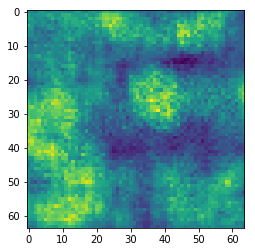

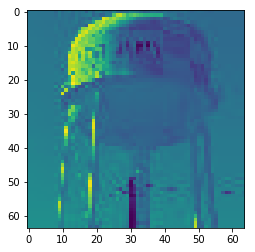

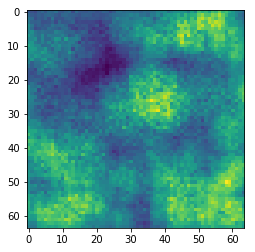

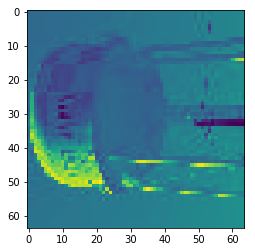

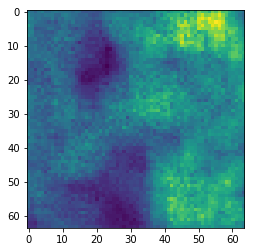

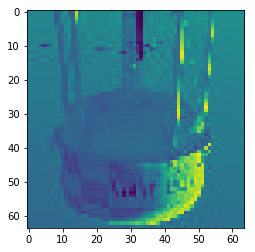

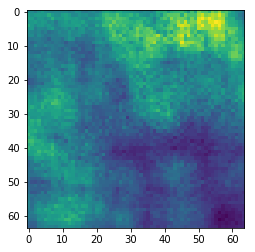

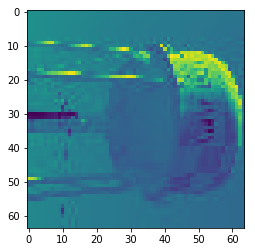

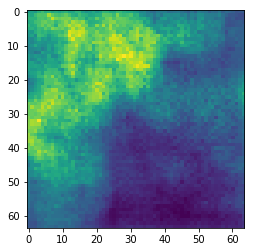

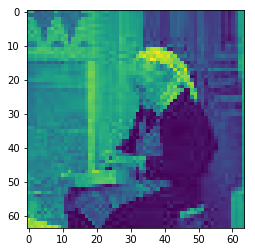

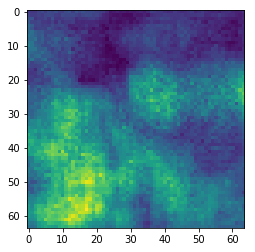

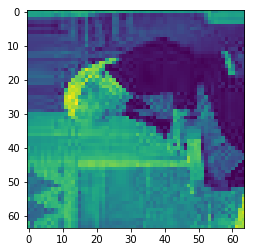

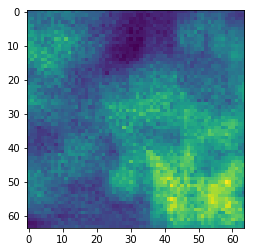

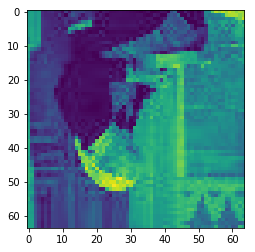

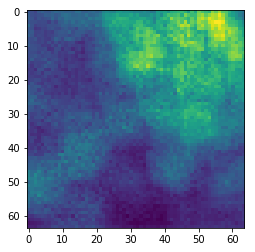

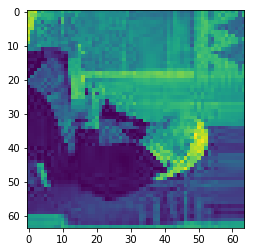

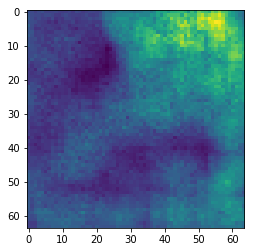

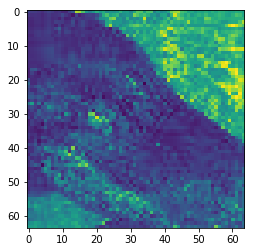

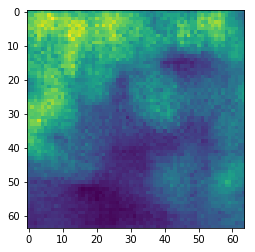

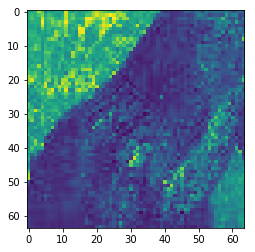

In [30]:
out = model.model(X_train[:10])

for i in range(10):
    plt.imshow(out.data[i, 0])
    plt.show()
    plt.imshow(Y_train[i])
    plt.show()

In [50]:
import optuna

In [76]:
print(n_test)

10000


In [105]:
def objective(trial):
    gpu_id = 0
    batchsize = 100
#     max_epoch = trial.suggest_discrete_uniform('max_epoch', 1, 5, 1)
    max_epoch = 20
    lr = trial.suggest_loguniform('lr', 1e-5, 1e-3)
    alpha = trial.suggest_uniform('alpha', 0.85, 1)
    lasso_alpha = trial.suggest_loguniform('lass_alpha', 1e-5, 1e-3)
    print('trial ', trial.number)
    print('max_epoch\t', max_epoch)
    print('lr\t', lr)
    print('alpha\t', alpha)
    print('lasso_alpha\t', lasso_alpha)

    train_iter = iterators.SerialIterator(train, batchsize)
    test_iter = iterators.SerialIterator(test, batchsize, False, False)

    preditor = MRICNN(X_train[0].shape)
    preditor.to_gpu(0)
    model = Minimizer(preditor, compute_cost)
    optimizer = optimizers.RMSprop(lr=lr, alpha=alpha)
    optimizer.setup(model)
#     optimizer.add_hook(chainer.optimizer_hooks.Lasso(lasso_alpha))

    updater = training.updaters.StandardUpdater(train_iter, optimizer, device=gpu_id)
    trainer = training.Trainer(updater, (max_epoch, 'epoch'), out='result')
    trainer.extend(extensions.Evaluator(test_iter, model, device=gpu_id))
    trainer.extend(extensions.snapshot_object(model.model, filename='model'),
               trigger=training.triggers.IntervalTrigger(max_epoch, unit='epoch'))

    trainer.extend(extensions.LogReport())
    trainer.extend(extensions.PrintReport(['epoch', 'main/loss', 'validation/main/loss', 'elapsed_time']))
    trainer.run()
    
    loss = []
    model.noise = False
    model.report = False
    for i in range(0, n_test, 100):
        x = X_train[i:i+100]
        y = Y_train[i:i+100]
        t = model(cuda.to_gpu(x), cuda.to_gpu(y))
        loss.append(cuda.to_cpu(t.data))
    loss = np.asarray(loss)
    loss = loss.sum() / n_test
    print(loss)
    return loss

In [106]:
%%time

study = optuna.create_study()
study.optimize(objective, n_trials=20)

trial  0
max_epoch	 20
lr	 3.81827112626e-05
alpha	 0.9970530098394268
lasso_alpha	 3.99450284058e-05
epoch       main/loss   validation/main/loss  elapsed_time
1           0.336956    0.0690466             22.8686       
2           0.0682806   0.07048               45.8993       
3           0.0614897   0.0553519             69.209        
4           0.0557932   0.0493051             92.7168       
5           0.0508338   0.0454289             116.306       
6           0.0475446   0.0424622             139.953       
7           0.0452297   0.0397191             163.947       
8           0.0435293   0.0390806             187.846       
9           0.0415434   0.0409046             211.839       
10          0.0404108   0.0375362             235.847       
11          0.0389107   0.0416111             259.875       
12          0.0379434   0.0392223             283.861       
13          0.0368442   0.0338292             307.824       
14          0.0360099   0.0341675             

[I 2019-04-06 14:37:58,303] Finished trial#0 resulted in value: 0.0004008727073669434. Current best value is 0.0004008727073669434 with parameters: {'lr': 3.8182711262629477e-05, 'alpha': 0.9970530098394268, 'lass_alpha': 3.9945028405759703e-05}.


trial  1
max_epoch	 20
lr	 0.000318158178205
alpha	 0.851537039853641
lasso_alpha	 1.28947986025e-05
epoch       main/loss   validation/main/loss  elapsed_time
1           0.522075    0.0451769             23.5417       
2           0.0473021   0.054835              47.0568       
3           0.0409908   0.0398599             70.8384       
4           0.0370265   0.0416757             94.6677       
5           0.0346415   0.0333226             118.422       
6           0.0326433   0.0307628             142.28        
7           0.0309128   0.0302813             166.054       
8           0.0298803   0.0283928             189.791       
9           0.0288151   0.0286013             213.549       
10          0.028035    0.0273621             237.386       
11          0.0273128   0.0259593             261.242       
12          0.0266205   0.0256731             285.049       
13          0.0261051   0.0259137             308.932       
14          0.0255516   0.030938              3

[I 2019-04-06 14:46:06,172] Finished trial#1 resulted in value: 0.0002464104175567627. Current best value is 0.0002464104175567627 with parameters: {'lr': 0.00031815817820463667, 'alpha': 0.851537039853641, 'lass_alpha': 1.2894798602496706e-05}.


trial  2
max_epoch	 20
lr	 7.40093191294e-05
alpha	 0.9538190064115131
lasso_alpha	 1.0055131978e-05
epoch       main/loss   validation/main/loss  elapsed_time
1           0.266109    0.0754346             23.7226       
2           0.0680271   0.0583345             47.6787       
3           0.0561026   0.0508345             71.8583       
4           0.0482861   0.0870471             96.1344       
5           0.0427947   0.0477107             120.539       
6           0.0385736   0.0373369             144.767       
7           0.0355393   0.039163              168.94        
8           0.0334056   0.0299136             193.322       
9           0.0319151   0.0291617             217.639       
10          0.0310356   0.034481              242.039       
11          0.0299859   0.0300949             266.307       
12          0.0292194   0.0277422             290.602       
13          0.0282732   0.0323284             315.087       
14          0.027447    0.027438              3

[I 2019-04-06 14:54:22,753] Finished trial#2 resulted in value: 0.00027817175388336184. Current best value is 0.0002464104175567627 with parameters: {'lr': 0.00031815817820463667, 'alpha': 0.851537039853641, 'lass_alpha': 1.2894798602496706e-05}.


trial  3
max_epoch	 20
lr	 0.000751606799274
alpha	 0.8651879934426635
lasso_alpha	 0.000300972466972
epoch       main/loss   validation/main/loss  elapsed_time
1           2.53016     0.0602182             23.618        
2           0.0606724   0.0474473             47.7914       
3           0.0448608   0.0349475             72.286        
4           0.0388048   0.0346498             96.4286       
5           0.0355006   0.0303763             120.462       
6           0.0332265   0.0304732             145.118       
7           0.0316542   0.0344985             169.164       
8           0.0306174   0.0336264             193.317       
9           0.0298825   0.0282577             217.248       
10          0.0291673   0.0295088             240.961       
11          0.0287709   0.0358976             264.816       
12          0.0283532   0.0281822             288.675       
13          0.0279886   0.0276274             312.398       
14          0.0275376   0.0275773             

[I 2019-04-06 15:02:32,279] Finished trial#3 resulted in value: 0.0002783292293548584. Current best value is 0.0002464104175567627 with parameters: {'lr': 0.00031815817820463667, 'alpha': 0.851537039853641, 'lass_alpha': 1.2894798602496706e-05}.


trial  4
max_epoch	 20
lr	 0.000118128278476
alpha	 0.9048862832941356
lasso_alpha	 0.0006681662339
epoch       main/loss   validation/main/loss  elapsed_time
1           0.191071    0.0528782             23.598        
2           0.0445421   0.035637              47.2941       
3           0.0367086   0.03568               71.2331       
4           0.0336545   0.0305824             95.3081       
5           0.0314512   0.0291776             119.428       
6           0.0301897   0.0280259             143.498       
7           0.0290663   0.029972              167.557       
8           0.0281851   0.0292159             191.691       
9           0.0274318   0.0284592             215.756       
10          0.0268747   0.0309498             239.774       
11          0.0263544   0.0283711             263.867       
12          0.0259584   0.0287746             287.929       
13          0.0254449   0.0258774             312.213       
14          0.0251148   0.0284212             33

[I 2019-04-06 15:10:45,077] Finished trial#4 resulted in value: 0.000248537540435791. Current best value is 0.0002464104175567627 with parameters: {'lr': 0.00031815817820463667, 'alpha': 0.851537039853641, 'lass_alpha': 1.2894798602496706e-05}.


trial  5
max_epoch	 20
lr	 0.00014299244061
alpha	 0.8902670603716809
lasso_alpha	 0.000217993425977
epoch       main/loss   validation/main/loss  elapsed_time
1           0.331191    0.127737              23.6789       
2           0.0899196   0.0703032             47.8398       
3           0.059211    0.0407702             72.2049       
4           0.0438506   0.0392824             96.5915       
5           0.0365103   0.0305411             121.04        
6           0.0333111   0.0309943             145.224       
7           0.0308278   0.0275153             169.793       
8           0.0293589   0.0288603             194.286       
9           0.028107    0.0263716             218.562       
10          0.0274239   0.0288448             243.117       
11          0.0266773   0.028742              267.489       
12          0.0259135   0.025032              291.844       
13          0.0254816   0.0300397             316.418       
14          0.0249464   0.0268715             3

[I 2019-04-06 15:19:02,489] Finished trial#5 resulted in value: 0.00024619479179382325. Current best value is 0.00024619479179382325 with parameters: {'lr': 0.00014299244061049556, 'alpha': 0.8902670603716809, 'lass_alpha': 0.00021799342597690198}.


trial  6
max_epoch	 20
lr	 0.000227099819691
alpha	 0.9006207603240681
lasso_alpha	 8.26714957225e-05
epoch       main/loss   validation/main/loss  elapsed_time
1           0.720756    0.0717183             23.6618       
2           0.0502966   0.0422214             47.2876       
3           0.0387297   0.0337545             71.2417       
4           0.0347592   0.0405389             95.1899       
5           0.0323424   0.0291385             119.131       
6           0.0306118   0.0275924             143.047       
7           0.0291572   0.0276608             166.946       
8           0.0280111   0.0273086             190.828       
9           0.0271947   0.0258807             214.655       
10          0.0264777   0.0256488             238.515       
11          0.0258494   0.0263525             262.347       
12          0.0252776   0.0252727             286.176       
13          0.0247713   0.0247501             309.967       
14          0.0244172   0.0276198             

[I 2019-04-06 15:27:10,269] Finished trial#6 resulted in value: 0.0002358123779296875. Current best value is 0.0002358123779296875 with parameters: {'lr': 0.00022709981969077335, 'alpha': 0.9006207603240681, 'lass_alpha': 8.2671495722483863e-05}.


trial  7
max_epoch	 20
lr	 0.000370906521841
alpha	 0.9678532746642972
lasso_alpha	 0.000784088557041
epoch       main/loss   validation/main/loss  elapsed_time
1           4.75293     0.110762              23.8745       
2           0.0797492   0.047121              47.7479       
3           0.0462084   0.0365362             71.7435       
4           0.0380719   0.0333733             95.7968       
5           0.034434    0.0342632             119.831       
6           0.0323603   0.0326985             144.098       
7           0.0310017   0.0278929             168.091       
8           0.0299433   0.0333679             192.236       
9           0.0293555   0.0280298             216.324       
10          0.0285169   0.027169              240.484       
11          0.0281048   0.0282393             264.561       
12          0.0274981   0.026493              288.525       
13          0.0271397   0.0281794             312.587       
14          0.0268702   0.0256078             

[I 2019-04-06 15:35:22,732] Finished trial#7 resulted in value: 0.0002504963159561157. Current best value is 0.0002358123779296875 with parameters: {'lr': 0.00022709981969077335, 'alpha': 0.9006207603240681, 'lass_alpha': 8.2671495722483863e-05}.


trial  8
max_epoch	 20
lr	 2.82120901295e-05
alpha	 0.9364491255474577
lasso_alpha	 0.000982301403864
epoch       main/loss   validation/main/loss  elapsed_time
1           0.257369    0.0571361             23.7879       
2           0.0570938   0.0701941             47.997        
3           0.050321    0.0503081             72.4494       
4           0.0468835   0.0395926             97.14         
5           0.0444582   0.0521734             121.626       
6           0.0424053   0.0396281             146.317       
7           0.0408759   0.0550546             170.772       
8           0.0393015   0.0443266             195.237       
9           0.0381069   0.0372695             219.952       
10          0.0371964   0.0394343             244.46        
11          0.036373    0.0399997             269.165       
12          0.0354583   0.0345041             293.633       
13          0.0347425   0.0397103             318.193       
14          0.0339905   0.0318781             

[I 2019-04-06 15:43:41,795] Finished trial#8 resulted in value: 0.0003061851978302002. Current best value is 0.0002358123779296875 with parameters: {'lr': 0.00022709981969077335, 'alpha': 0.9006207603240681, 'lass_alpha': 8.2671495722483863e-05}.


trial  9
max_epoch	 20
lr	 0.000138947086593
alpha	 0.9659775786412564
lasso_alpha	 8.65346581696e-05
epoch       main/loss   validation/main/loss  elapsed_time
1           0.810251    0.112798              23.9511       
2           0.0832357   0.0570922             47.7786       
3           0.0534386   0.046905              71.8896       
4           0.0456827   0.0371671             96.0119       
5           0.0421111   0.0567772             120.092       
6           0.0399003   0.0337451             144.191       
7           0.0379229   0.0366253             168.261       
8           0.0366989   0.0457185             192.3         
9           0.0353692   0.0337257             216.309       
10          0.0345766   0.0305781             240.273       
11          0.0337122   0.0311456             264.25        
12          0.0330238   0.0327516             288.183       
13          0.032291    0.0315193             312.111       
14          0.031767    0.0322595             

[I 2019-04-06 15:51:53,352] Finished trial#9 resulted in value: 0.0002756368398666382. Current best value is 0.0002358123779296875 with parameters: {'lr': 0.00022709981969077335, 'alpha': 0.9006207603240681, 'lass_alpha': 8.2671495722483863e-05}.


trial  10
max_epoch	 20
lr	 1.00503165786e-05
alpha	 0.886357572483
lasso_alpha	 3.88527280238e-05
epoch       main/loss   validation/main/loss  elapsed_time
1           0.807653    0.213428              23.9821       
2           0.156096    0.120247              48.0067       
3           0.106607    0.0934664             74.2801       
4           0.0882902   0.0809634             100.677       
5           0.0784344   0.0733603             127.022       
6           0.0718391   0.0685531             153.371       
7           0.067196    0.0642532             179.72        
8           0.0635684   0.0620835             206.067       
9           0.060692    0.058753              232.415       
10          0.0582671   0.0579941             258.769       
11          0.0561002   0.0572062             285.118       
12          0.0542399   0.0530713             311.47        
13          0.0525765   0.0516396             337.821       
14          0.0511619   0.0503655             364

[I 2019-04-06 16:00:46,896] Finished trial#10 resulted in value: 0.00045625877380371096. Current best value is 0.0002358123779296875 with parameters: {'lr': 0.00022709981969077335, 'alpha': 0.9006207603240681, 'lass_alpha': 8.2671495722483863e-05}.


trial  11
max_epoch	 20
lr	 2.67606783775e-05
alpha	 0.920594753398
lasso_alpha	 9.74480111421e-05
epoch       main/loss   validation/main/loss  elapsed_time
1           0.579889    0.193564              26.3416       
2           0.157523    0.132976              52.7128       
3           0.113933    0.105976              79.0697       
4           0.0944569   0.0869889             105.422       
5           0.0837332   0.0989997             131.814       
6           0.0769969   0.0760657             158.203       
7           0.0719468   0.06603               184.602       
8           0.0688675   0.0637973             210.97        
9           0.0658059   0.0592061             237.373       
10          0.0637212   0.0587999             263.77        
11          0.0615979   0.0554598             290.138       
12          0.0600018   0.0620781             316.505       
13          0.0584038   0.0543021             342.881       
14          0.0569594   0.0580445             369

[I 2019-04-06 16:09:45,573] Finished trial#11 resulted in value: 0.0004626204013824463. Current best value is 0.0002358123779296875 with parameters: {'lr': 0.00022709981969077335, 'alpha': 0.9006207603240681, 'lass_alpha': 8.2671495722483863e-05}.


trial  12
max_epoch	 20
lr	 0.000348387407505
alpha	 0.873920765034
lasso_alpha	 3.95779016538e-05
epoch       main/loss   validation/main/loss  elapsed_time
1           1.0528      0.049715              25.9318       
2           0.0432473   0.0355242             51.6298       
3           0.0364042   0.0387646             77.3164       
4           0.0333769   0.0347407             103.017       
5           0.0316462   0.0345195             128.741       
6           0.0305123   0.0289326             154.461       
7           0.0292547   0.027003              180.174       
8           0.0285036   0.0298323             205.876       
9           0.0278551   0.0292841             231.558       
10          0.0271237   0.0311745             257.227       
11          0.0267573   0.0284681             282.919       
12          0.0262264   0.0253279             308.607       
13          0.0258163   0.0264974             334.297       
14          0.0253435   0.0250835             360

[I 2019-04-06 16:18:31,312] Finished trial#12 resulted in value: 0.00024241194725036622. Current best value is 0.0002358123779296875 with parameters: {'lr': 0.00022709981969077335, 'alpha': 0.9006207603240681, 'lass_alpha': 8.2671495722483863e-05}.


trial  13
max_epoch	 20
lr	 0.000997288721198
alpha	 0.913226590868
lasso_alpha	 0.000301347465538
epoch       main/loss   validation/main/loss  elapsed_time
1           4.31843     0.0747627             26.3072       
2           0.0570812   0.0508129             51.9751       
3           0.0416866   0.0357508             77.5376       
4           0.0373309   0.0364767             103.055       
5           0.0348714   0.0315219             128.546       
6           0.0335521   0.0308811             154.035       
7           0.0326474   0.030783              179.516       
8           0.0317905   0.0312362             204.992       
9           0.0312594   0.0304277             230.48        
10          0.0306903   0.0302629             255.953       
11          0.0303146   0.0315218             281.424       
12          0.0298322   0.0296748             306.898       
13          0.029554    0.0296355             332.381       
14          0.0293845   0.0323297             357

[I 2019-04-06 16:27:13,616] Finished trial#13 resulted in value: 0.000289623236656189. Current best value is 0.0002358123779296875 with parameters: {'lr': 0.00022709981969077335, 'alpha': 0.9006207603240681, 'lass_alpha': 8.2671495722483863e-05}.


trial  14
max_epoch	 20
lr	 1.54568735917e-05
alpha	 0.941777626791
lasso_alpha	 1.61030182397e-05
epoch       main/loss   validation/main/loss  elapsed_time
1           0.397906    0.0653713             26.3307       
2           0.0540886   0.046281              52.6708       
3           0.0436028   0.0402763             78.9972       
4           0.0390669   0.0372545             105.323       
5           0.0365936   0.0360465             131.65        
6           0.0348638   0.0341718             157.975       
7           0.0335468   0.0338645             184.304       
8           0.0325375   0.0324449             210.628       
9           0.031704    0.0318446             236.951       
10          0.0309263   0.0331187             263.278       
11          0.0303033   0.0325013             289.604       
12          0.0297566   0.0319843             315.919       
13          0.0292172   0.0302403             342.13        
14          0.0287547   0.0299022             368

[I 2019-04-06 16:36:10,759] Finished trial#14 resulted in value: 0.0002910658597946167. Current best value is 0.0002358123779296875 with parameters: {'lr': 0.00022709981969077335, 'alpha': 0.9006207603240681, 'lass_alpha': 8.2671495722483863e-05}.


trial  15
max_epoch	 20
lr	 5.52664061803e-05
alpha	 0.901505625243
lasso_alpha	 0.00018316816501
epoch       main/loss   validation/main/loss  elapsed_time
1           0.282251    0.0669913             26.2849       
2           0.0674172   0.0610776             52.4045       
3           0.0565225   0.054775              78.6256       
4           0.0492391   0.0493624             104.896       
5           0.0434361   0.0384206             131.098       
6           0.0400098   0.0433734             157.387       
7           0.0374149   0.0477159             183.716       
8           0.0355395   0.031933              210.002       
9           0.0336043   0.0467747             236.272       
10          0.0323902   0.0306412             262.54        
11          0.0312513   0.0303173             288.851       
12          0.0302243   0.0338294             315.173       
13          0.0293762   0.0287504             341.507       
14          0.0286859   0.0286842             367.

[I 2019-04-06 16:45:07,802] Finished trial#15 resulted in value: 0.00027329933643341066. Current best value is 0.0002358123779296875 with parameters: {'lr': 0.00022709981969077335, 'alpha': 0.9006207603240681, 'lass_alpha': 8.2671495722483863e-05}.


trial  16
max_epoch	 20
lr	 0.000606706073047
alpha	 0.868536509315
lasso_alpha	 2.47094668396e-05
epoch       main/loss   validation/main/loss  elapsed_time
1           1.21661     0.0633616             26.3077       
2           0.0596101   0.0441638             52.4087       
3           0.0431859   0.0410903             78.2503       
4           0.0367921   0.0358159             104.013       
5           0.0336768   0.0325554             129.756       
6           0.0317603   0.0321267             155.474       
7           0.0305156   0.0304815             181.135       
8           0.0295597   0.0298026             206.79        
9           0.0288019   0.0296447             232.447       
10          0.0282053   0.0272391             258.109       
11          0.0276867   0.0289383             283.758       
12          0.0272331   0.0269762             309.402       
13          0.0269825   0.0284647             334.998       
14          0.0266416   0.0264185             360

[I 2019-04-06 16:53:53,226] Finished trial#16 resulted in value: 0.0002616569757461548. Current best value is 0.0002358123779296875 with parameters: {'lr': 0.00022709981969077335, 'alpha': 0.9006207603240681, 'lass_alpha': 8.2671495722483863e-05}.


trial  17
max_epoch	 20
lr	 0.000281803299835
alpha	 0.868946951583
lasso_alpha	 5.58373663143e-05
epoch       main/loss   validation/main/loss  elapsed_time
1           0.642513    0.0509977             26.2426       
2           0.0449233   0.0342336             52.3461       
3           0.0371539   0.0313016             78.435        
4           0.0342756   0.0315107             104.626       
5           0.0323149   0.0310773             130.811       
6           0.0310785   0.0296765             157.025       
7           0.0299974   0.0282395             183.299       
8           0.0292355   0.0281926             209.401       
9           0.0285716   0.0311197             235.369       
10          0.0279295   0.0341867             261.361       
11          0.0274917   0.0262018             287.257       
12          0.0269382   0.0279363             313.179       
13          0.0265169   0.0273585             339.002       
14          0.0261059   0.0286344             364

[I 2019-04-06 17:02:44,018] Finished trial#17 resulted in value: 0.00026563007831573485. Current best value is 0.0002358123779296875 with parameters: {'lr': 0.00022709981969077335, 'alpha': 0.9006207603240681, 'lass_alpha': 8.2671495722483863e-05}.


trial  18
max_epoch	 20
lr	 0.00022638280863
alpha	 0.884007182996
lasso_alpha	 5.82253273954e-05
epoch       main/loss   validation/main/loss  elapsed_time
1           0.449994    0.0747872             26.0309       
2           0.0561032   0.0484995             52.0446       
3           0.0446644   0.0396562             78.061        
4           0.0396641   0.0372651             104.141       
5           0.0364246   0.0339013             130.073       
6           0.0338947   0.0331014             156.032       
7           0.0324075   0.0294374             182.046       
8           0.0310855   0.0286794             208.043       
9           0.0299118   0.0279629             234.054       
10          0.0290474   0.0277415             260.028       
11          0.0285193   0.0298881             286.058       
12          0.0276926   0.0316337             312.137       
13          0.0271035   0.0277132             338.294       
14          0.0265835   0.0281655             364.

[I 2019-04-06 17:11:36,345] Finished trial#18 resulted in value: 0.0002504806995391846. Current best value is 0.0002358123779296875 with parameters: {'lr': 0.00022709981969077335, 'alpha': 0.9006207603240681, 'lass_alpha': 8.2671495722483863e-05}.


trial  19
max_epoch	 20
lr	 0.000523304076872
alpha	 0.852640040267
lasso_alpha	 2.3148045213e-05
epoch       main/loss   validation/main/loss  elapsed_time
1           0.667724    0.104329              26.3342       
2           0.0604794   0.0536931             52.6232       
3           0.0496418   0.0548927             78.9657       
4           0.0434778   0.0521085             105.307       
5           0.0394606   0.0507249             131.616       
6           0.03662     0.0364731             157.956       
7           0.0346873   0.0340769             184.3         
8           0.0330368   0.0303195             210.639       
9           0.0317136   0.028093              236.977       
10          0.0306863   0.0292785             263.299       
11          0.0295638   0.0294014             289.622       
12          0.0288934   0.0318187             315.889       
13          0.0282543   0.0272265             342.152       
14          0.0277298   0.0269885             368.

[I 2019-04-06 17:20:33,807] Finished trial#19 resulted in value: 0.0002646821975708008. Current best value is 0.0002358123779296875 with parameters: {'lr': 0.00022709981969077335, 'alpha': 0.9006207603240681, 'lass_alpha': 8.2671495722483863e-05}.


CPU times: user 1h 55min 56s, sys: 54min 38s, total: 2h 50min 34s
Wall time: 2h 50min 42s


In [107]:
study.best_params

{'alpha': 0.9006207603240681,
 'lass_alpha': 8.2671495722483863e-05,
 'lr': 0.00022709981969077335}

In [108]:
predictor = MRICNN(X_train[0].shape)
serializers.load_npz('./result/model', predictor)

In [109]:
i = 100

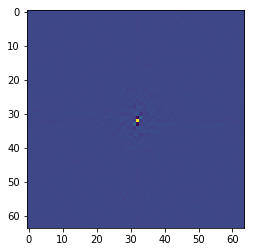

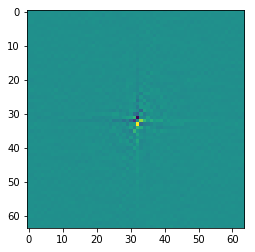

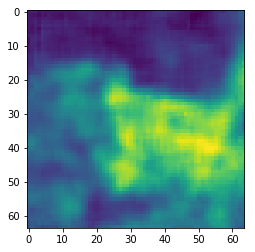

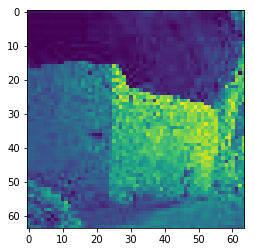

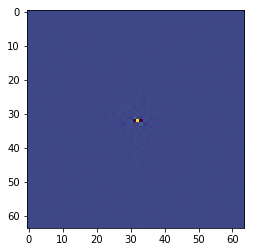

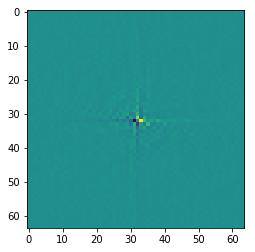

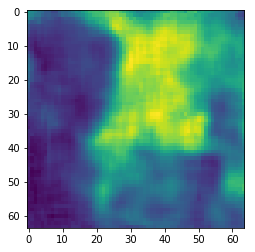

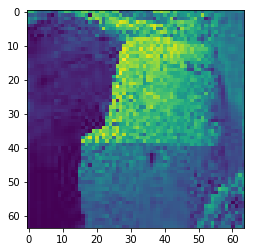

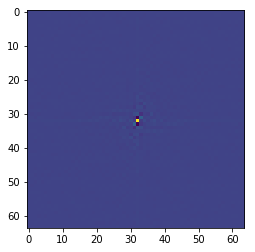

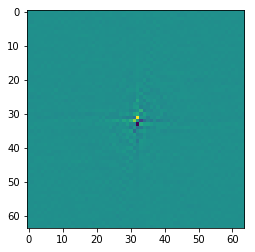

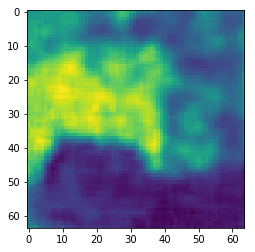

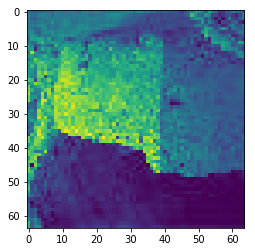

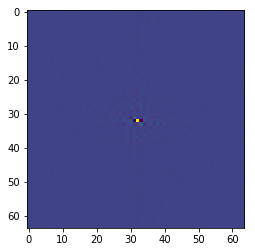

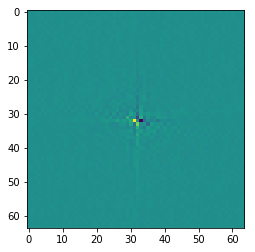

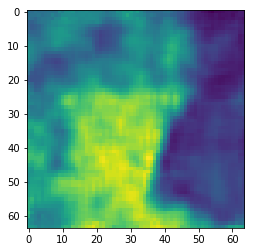

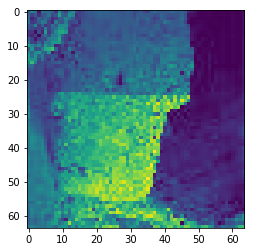

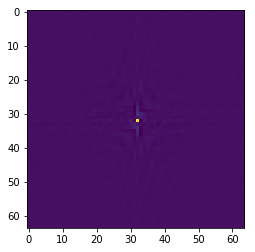

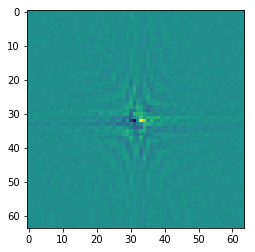

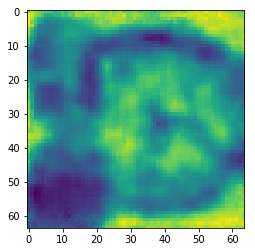

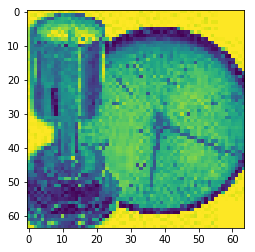

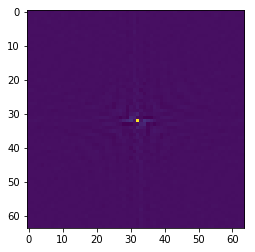

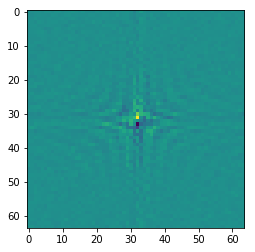

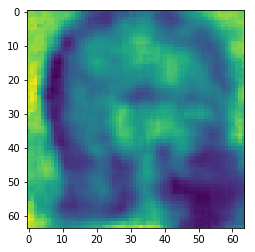

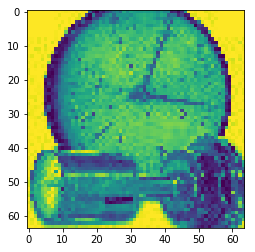

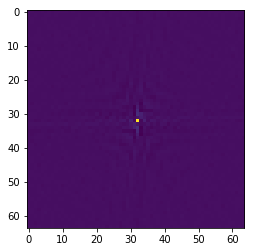

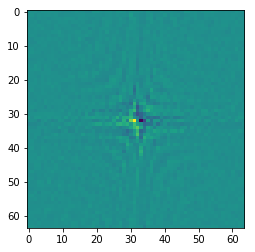

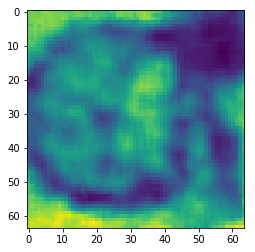

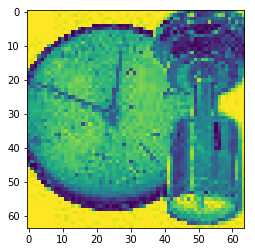

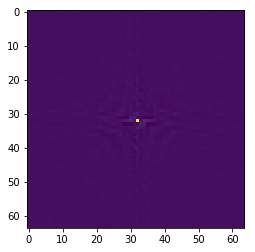

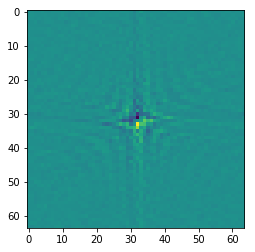

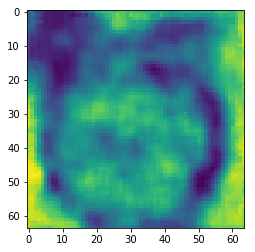

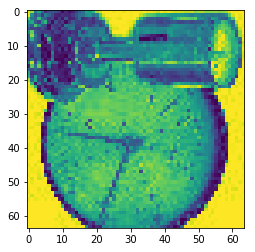

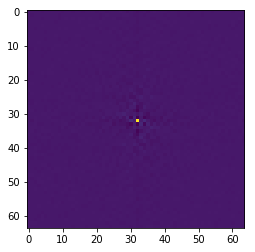

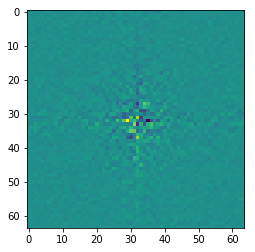

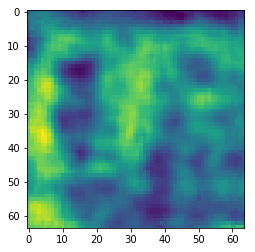

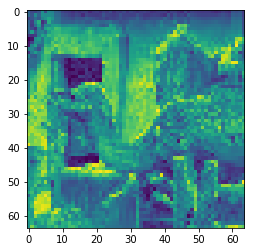

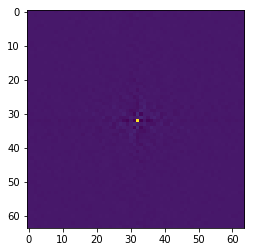

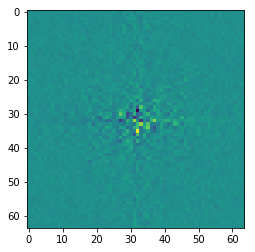

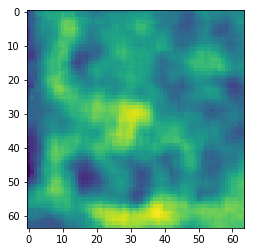

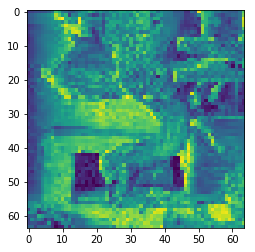

In [118]:
j = 100
out = predictor(X_train[j:j+10])

for i in range(10):
    plt.imshow(X_train[j+i][:, :, 0])
    plt.show()    
    plt.imshow(X_train[j+i][:, :, 1])
    plt.show()    
    plt.imshow(out.data[i, 0])
    plt.show()
    plt.imshow(Y_train[j+i])
    plt.show()